In [13]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Path to the folder containing the stock CSV files
stock_data_folder = '/home/ayalk94/Documents/GitHub/week-long-challenge/Data/yfinance_data/'

# Load all CSV files into a list of DataFrames
csv_files = glob.glob(os.path.join(stock_data_folder, "*.csv"))

# Combine all the CSV files into one DataFrame
stock_df_list = [pd.read_csv(file) for file in csv_files]
combined_stock_df = pd.concat(stock_df_list, ignore_index=True)

# Convert Date column to datetime64[ns] format
combined_stock_df['Date'] = pd.to_datetime(combined_stock_df['Date'], errors='coerce')

# Check if the conversion worked and if there are any NaT values
print(combined_stock_df['Date'].dtypes)  # Should be datetime64[ns]
print(combined_stock_df['Date'].isnull().sum())  # Check for NaT values

# Load the news data
news_df = pd.read_csv('/home/ayalk94/Documents/GitHub/week-long-challenge/Data/raw_analyst_ratings.csv')

# Convert news date column to datetime64[ns], removing timezones if necessary
news_df = news_df.rename(columns={'date': 'Date'})
news_df['Date'] = pd.to_datetime(news_df['Date'], errors='coerce')

# If there is timezone information, remove it
news_df['Date'] = news_df['Date'].dt.tz_localize(None)

# Check the types to ensure date columns match
print(news_df['Date'].dtypes)  # Should be datetime64[ns]
print(news_df['Date'].isnull().sum())  # Check for NaT values

# Drop rows with NaT in date columns
combined_stock_df.dropna(subset=['Date'], inplace=True)
news_df.dropna(subset=['Date'], inplace=True)

# Merge the news and combined stock data based on the date
merged_df = pd.merge(combined_stock_df, news_df, left_on='Date', right_on='Date', how='inner')

# Check the merged dataset
print("Merged Data Shape:", merged_df.shape)
print(merged_df.head())


datetime64[ns]
0
datetime64[ns]
1351341
Merged Data Shape: (0, 14)
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume, Dividends, Stock Splits, Unnamed: 0, headline, url, publisher, stock]
Index: []


In [5]:
combined_stock_df['Date']

0       2004-08-19
1       2004-08-20
2       2004-08-23
3       2004-08-24
4       2004-08-25
           ...    
45423   2024-07-24
45424   2024-07-25
45425   2024-07-26
45426   2024-07-29
45427   2024-07-30
Name: Date, Length: 45428, dtype: datetime64[ns]

In [16]:
news_df['Date']

0          2020-06-05
1          2020-06-03
2          2020-05-26
3          2020-05-22
4          2020-05-22
              ...    
1407266    2018-01-05
1407267    2017-12-06
1407268    2017-12-06
1407269    2017-11-15
1407270    2017-11-14
Name: Date, Length: 55987, dtype: object

In [14]:
# Ensure both Date columns are datetime without timezone or time components
news_df['Date'] = pd.to_datetime(news_df['Date']).dt.date
combined_stock_df['Date'] = pd.to_datetime(combined_stock_df['Date']).dt.date

# Confirm both columns are now properly aligned
print(news_df['Date'].dtype)
print(combined_stock_df['Date'].dtype)


object
object


In [18]:
# Strip any leading/trailing whitespace
news_df['Date'] = news_df['Date'].astype(str).str.strip()
combined_stock_df['Date'] = combined_stock_df['Date'].astype(str).str.strip()

# Convert them back to datetime
news_df['Date'] = pd.to_datetime(news_df['Date'])
combined_stock_df['Date'] = pd.to_datetime(combined_stock_df['Date'])


In [10]:
# Get unique dates in both datasets
news_dates = set(news_df['Date'].unique())
stock_dates = set(combined_stock_df['Date'].unique())

# Check if there are any overlaps
common_dates = news_dates.intersection(stock_dates)
print(f"Number of common dates: {len(common_dates)}")

# Optionally, print a few common dates
print(list(common_dates)[:10])


Number of common dates: 2226
[Timestamp('2018-11-01 00:00:00'), Timestamp('2016-12-15 00:00:00'), Timestamp('2015-05-18 00:00:00'), Timestamp('2017-03-09 00:00:00'), Timestamp('2017-06-14 00:00:00'), Timestamp('2015-02-19 00:00:00'), Timestamp('2018-01-12 00:00:00'), Timestamp('2014-08-18 00:00:00'), Timestamp('2019-09-17 00:00:00'), Timestamp('2018-10-23 00:00:00')]


In [19]:
# Perform a left join
debug_merge = pd.merge(news_df, combined_stock_df, on='Date', how='left')

# Display rows where there are no matches from the stock data
missing_matches = debug_merge[debug_merge['Open'].isnull()]
print(missing_matches[['Date', 'headline', 'publisher']].head())

# Check the shape of the missing_matches DataFrame
print("Number of missing matches:", missing_matches.shape[0])


           Date                                           headline  \
3308 2020-05-23  Notable Insider Buys This Past Week: Berkshire...   
3785 2014-10-26                     Benzinga's Weekend M&A Chatter   
3786 2014-10-26  Williams, Williams Partners L.P., Access Midst...   
3990 2020-05-03  The Week Ahead In Biotech: Smid-Cap Earnings N...   
4432 2019-04-21                     A Second Marijuana ETF Ignites   

             publisher  
3308        Nelson Hem  
3785     Charles Gross  
3786     Charles Gross  
3990  Shanthi Rexaline  
4432     ETF Professor  
Number of missing matches: 757


### calculate sentiment using TextBlob

In [20]:
from textblob import TextBlob

# Function to calculate sentiment using TextBlob
def get_sentiment(headline):
    analysis = TextBlob(headline)
    return analysis.sentiment.polarity

# Apply sentiment analysis on the news headlines
debug_merge['sentiment'] = debug_merge['headline'].apply(get_sentiment)

# Check sentiment scores
print(debug_merge[['headline', 'sentiment']].head())


                                  headline  sentiment
0  Stocks That Hit 52-Week Highs On Friday        0.0
1  Stocks That Hit 52-Week Highs On Friday        0.0
2  Stocks That Hit 52-Week Highs On Friday        0.0
3  Stocks That Hit 52-Week Highs On Friday        0.0
4  Stocks That Hit 52-Week Highs On Friday        0.0


### Calculate Daily Stock Returns

#### Compute Daily Returns

In [22]:
# Calculate daily returns
debug_merge['Daily_Return'] = debug_merge['Close'].pct_change()

# Drop rows with NaN values (resulting from the pct_change calculation)
debug_merge = debug_merge.dropna()

# Display the first few rows with daily returns
print(debug_merge[['Date', 'Close', 'Daily_Return']].head())


/tmp/ipykernel_5392/1624205746.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  debug_merge['Daily_Return'] = debug_merge['Close'].pct_change()


        Date       Close  Daily_Return
1 2020-06-05   82.875000      0.152330
2 2020-06-05   59.043999     -0.287554
3 2020-06-05  124.150002      1.102669
4 2020-06-05  187.199997      0.507853
5 2020-06-05  230.770004      0.232746


### Perform Correlation Analysis

#### Aggregate Sentiment Scores

In [24]:
# Aggregate sentiment scores by date (average sentiment)
daily_sentiment = debug_merge.groupby('Date')['sentiment'].mean().reset_index()

# Merge aggregated sentiment scores with daily returns
final_df = pd.merge(daily_sentiment, debug_merge[['Date', 'Daily_Return']], on='Date')

# Display the final dataset for correlation analysis
print(final_df.head())


        Date  sentiment  Daily_Return
0 2011-04-27        0.0     26.730428
1 2011-04-27        0.0     -0.066332
2 2011-04-27        0.0     -0.855635
3 2011-04-27        0.0      4.445810
4 2011-04-27        0.0      1.683212


### Calculate Pearson Correlation

In [26]:
# Calculate correlation
correlation = final_df['sentiment'].corr(final_df['Daily_Return'])

print(f'Correlation between news sentiment and stock returns: {correlation:.2f}')


Correlation between news sentiment and stock returns: 0.01


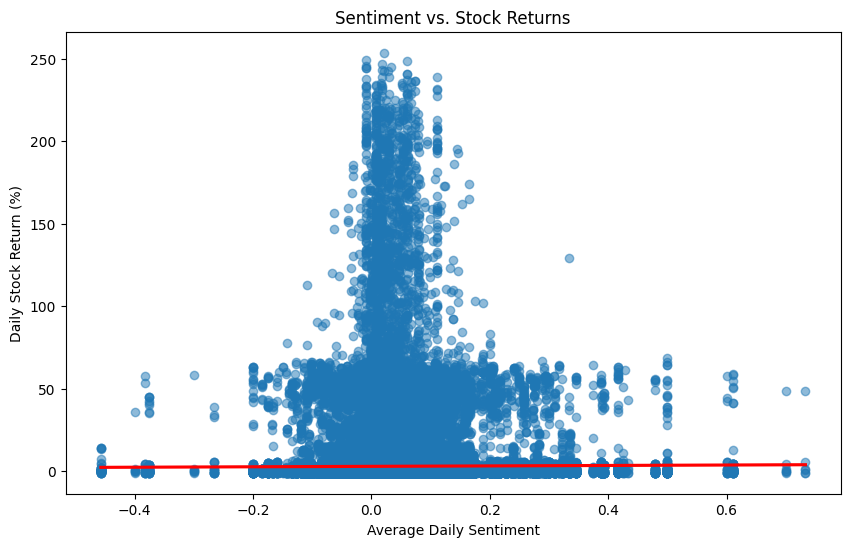

In [28]:


# Plot a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='sentiment', y='Daily_Return', data=final_df, scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
plt.title('Sentiment vs. Stock Returns')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Stock Return (%)')
plt.show()


### Advanced Sentiment Analysis Using VADER

In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download the necessary VADER lexicon
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment using VADER
def get_vader_sentiment(headline):
    sentiment_dict = sia.polarity_scores(headline)
    return sentiment_dict['compound']  # Compound score between -1 (negative) and 1 (positive)

# Apply VADER sentiment analysis on the news headlines
debug_merge['vader_sentiment'] = debug_merge['headline'].apply(get_vader_sentiment)

# Check sentiment scores
print(debug_merge[['headline', 'vader_sentiment']].head())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ayalk94/nltk_data...


                                  headline  vader_sentiment
1  Stocks That Hit 52-Week Highs On Friday              0.0
2  Stocks That Hit 52-Week Highs On Friday              0.0
3  Stocks That Hit 52-Week Highs On Friday              0.0
4  Stocks That Hit 52-Week Highs On Friday              0.0
5  Stocks That Hit 52-Week Highs On Friday              0.0


### Exploratory Data Analysis (EDA)

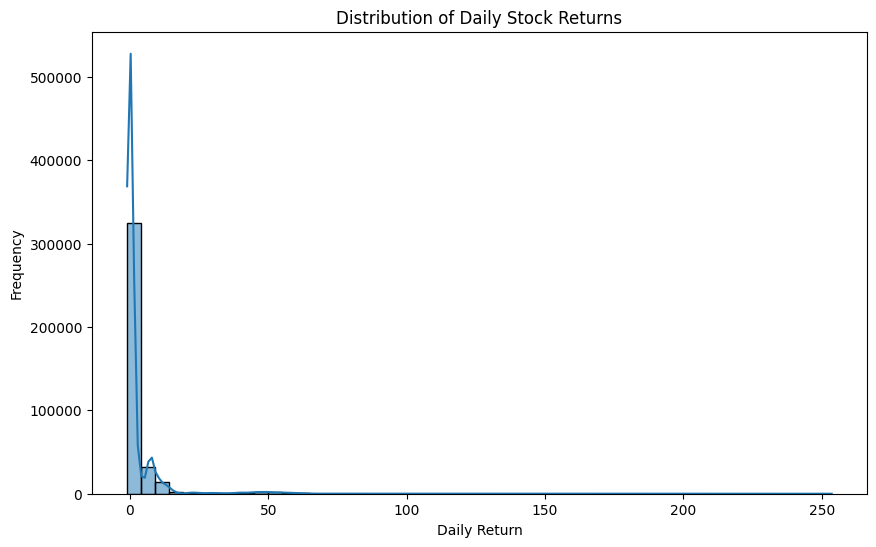

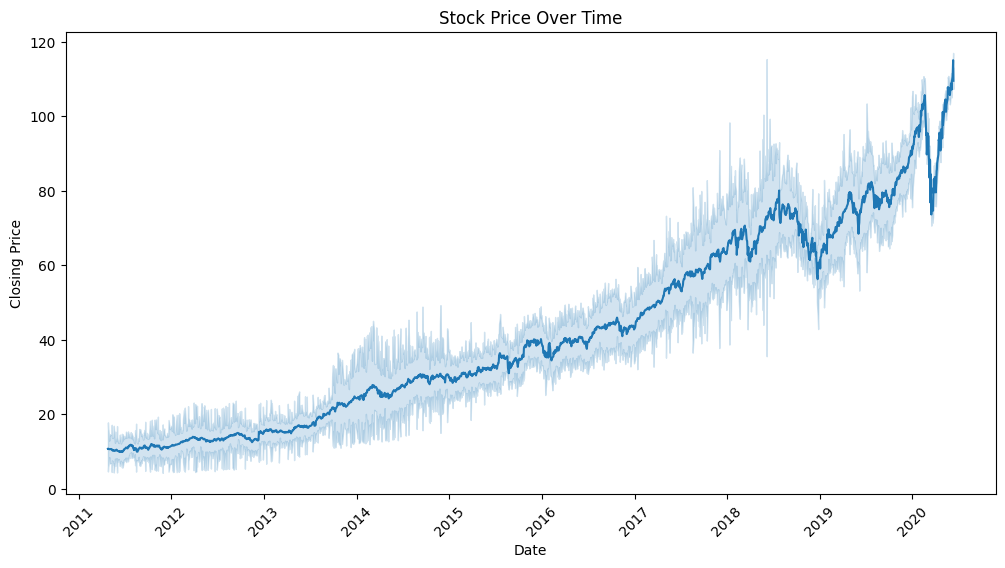

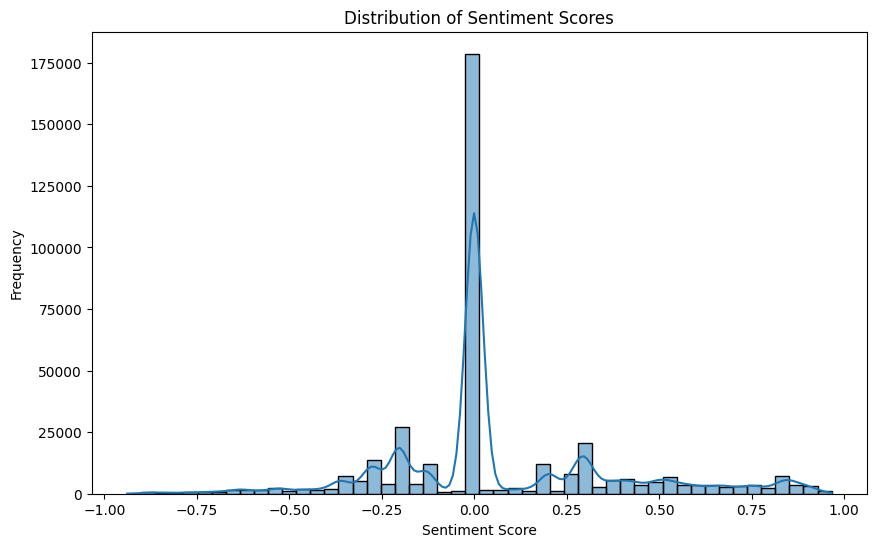

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of daily returns
plt.figure(figsize=(10, 6))
sns.histplot(debug_merge['Daily_Return'].dropna(), kde=True, bins=50)
plt.title('Distribution of Daily Stock Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

# Time series plot of stock prices
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Close', data=debug_merge)
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.show()

# Sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(debug_merge['vader_sentiment'].dropna(), kde=True, bins=50)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


### Multiple Stock Tickers

#### If your stock data contains multiple tickers, you can group them and perform analysis for each stock individually.

In [31]:
# Group by stock ticker and calculate daily returns for each stock
debug_merge['daily_return'] = debug_merge.groupby('stock')['Close'].pct_change()

# Group by stock and date to get sentiment and returns
grouped_df = debug_merge.groupby(['stock', 'Date']).agg({
    'vader_sentiment': 'mean',
    'daily_return': 'first'
}).reset_index()

# Check the grouped data
print(grouped_df.head())


  stock       Date  vader_sentiment  daily_return
0     A 2020-05-22           0.0480      7.089359
1     A 2020-05-26           0.0000      7.079252
2     A 2020-06-03           0.0000      7.051457
3     A 2020-06-05           0.0000     -0.287554
4    AA 2020-05-18           0.8519      6.937484


### Modeling the Relationship Between Sentiment and Stock Returns

##### Apply machine learning models, like linear regression, to analyze the relationship between sentiment and returns.

Model Coefficient: -0.5608966436529479
Model Intercept: 13.636368820030723


/home/ayalk94/Documents/GitHub/week-long-challenge/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


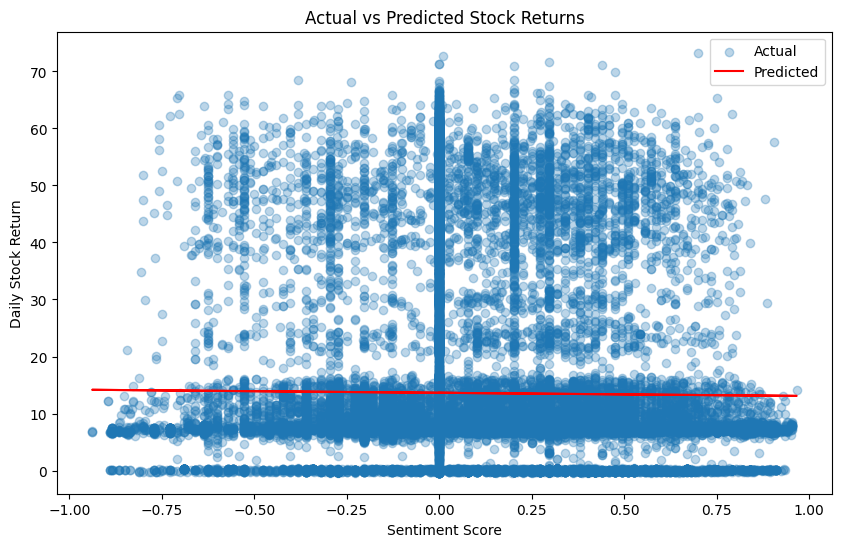

In [33]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare data for regression analysis
X = grouped_df[['vader_sentiment']].fillna(0)
y = grouped_df['daily_return'].fillna(0)

# Initialize and fit the regression model
model = LinearRegression()
model.fit(X, y)

# Predict returns based on sentiment
predicted_returns = model.predict(X)

# Evaluate the model
print(f'Model Coefficient: {model.coef_[0]}')
print(f'Model Intercept: {model.intercept_}')

# Plot actual vs predicted returns
plt.figure(figsize=(10, 6))
plt.scatter(grouped_df['vader_sentiment'], grouped_df['daily_return'], alpha=0.3, label='Actual')
plt.plot(grouped_df['vader_sentiment'], predicted_returns, color='red', label='Predicted')
plt.title('Actual vs Predicted Stock Returns')
plt.xlabel('Sentiment Score')
plt.ylabel('Daily Stock Return')
plt.legend()
plt.show()


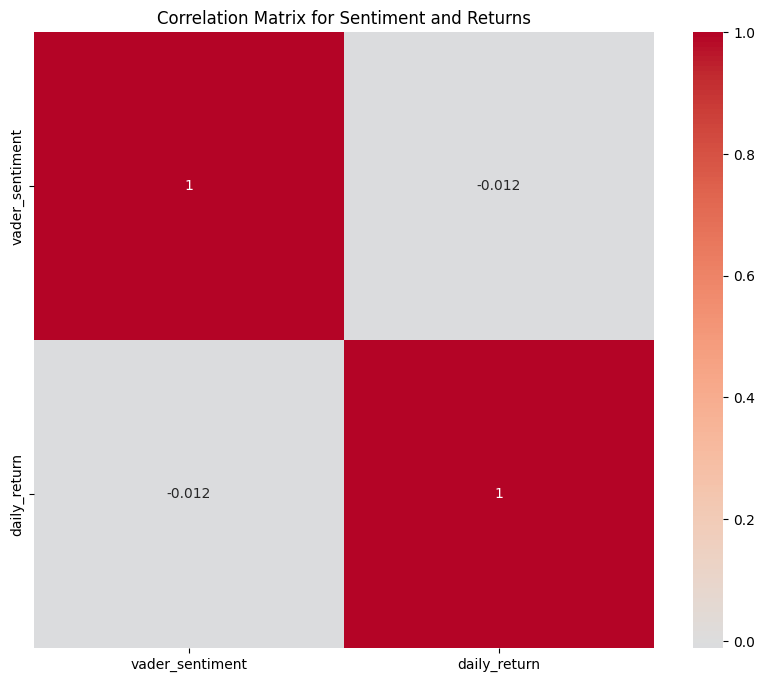

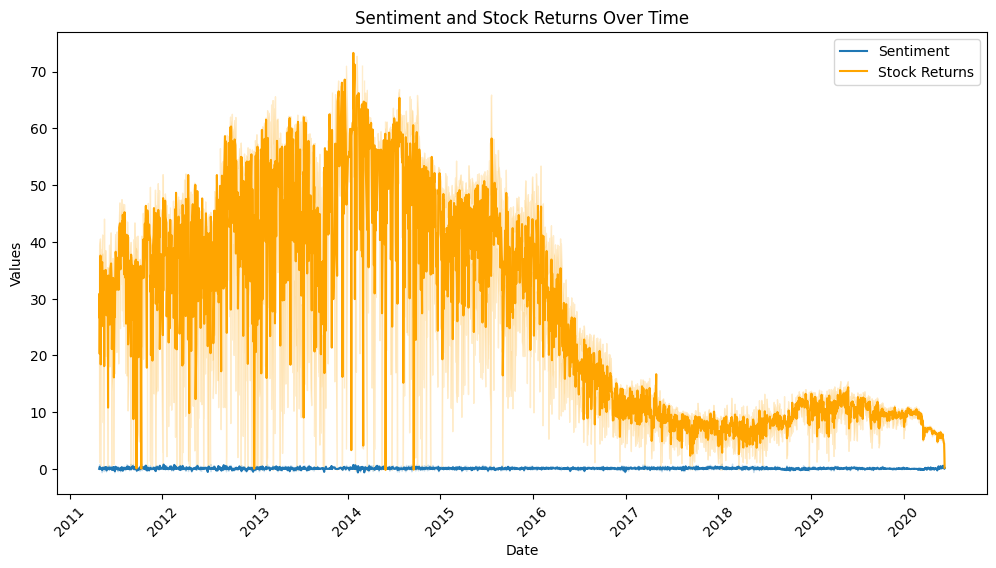

In [35]:
# Filter out non-numeric columns
numeric_df = grouped_df.select_dtypes(include=['float64', 'int64'])

# Heatmap to show correlation between variables
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for Sentiment and Returns')
plt.show()

# Time series of sentiment and returns
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='vader_sentiment', data=grouped_df, label='Sentiment')
sns.lineplot(x='Date', y='daily_return', data=grouped_df, label='Stock Returns', color='orange')
plt.title('Sentiment and Stock Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.show()
